# Evaluación de experimentos (Numbers + IDG: dsprites / shapes3d / mpi3d)

Este notebook **no re-evalúa modelos**: lee los logs (`metrics.csv`) y (si existen) los checkpoints (`ckpt_ep*.pt`) para extraer metadata (dataset, modo, etc.), y genera:

- Tablas **por dataset** con métricas en **test** (seleccionando el mejor checkpoint por **val**).
- Curvas (train/val/test) por método, agregadas por seed.
- Resúmenes exportables a CSV.

> Estructura esperada:  
`<RUNS_ROOT>/<run_name>/seed_<seed>/{metrics.csv, checkpoints/ckpt_ep*.pt}`


In [1]:
# =========================
# Imports
# =========================
from __future__ import annotations

import re
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


## 1) Configuración

Ajusta `RUNS_ROOT` si tu carpeta de runs está en otro lugar.


In [2]:
# =========================
# Configuración
# =========================
RUNS_ROOT = Path("./runs")   # <-- cambia si aplica
METRICS_CSV_NAME = "metrics.csv"

# Selección de checkpoint "best" por val:
# - Si existe "acc_mean" en val, maximizamos.
# - Si no, minimizamos "loss" en val.
PREFER_VAL_METRIC = None  # None = auto (acc_mean si existe, si no loss)

# Si quieres filtrar runs por nombre (regex). Ej: r"(baseline|swap)"
RUN_FILTER_REGEX = None

# Si quieres filtrar datasets: ["numbers","shapes3d",...]
DATASET_FILTER = None

# Export opcional
EXPORT_DIR = Path("./eval_exports")
EXPORT_DIR.mkdir(exist_ok=True, parents=True)

print("RUNS_ROOT =", RUNS_ROOT.resolve())


RUNS_ROOT = /workspace1/asoto/araymond/swap_pixels/runs


In [3]:
# =========================
# Helpers: descubrir runs y cargar config desde ckpt
# =========================

def _epoch_from_name(p: Path) -> int:
    m = re.search(r"ckpt_ep(\d+)\.pt", p.name)
    return int(m.group(1)) if m else -1

def find_latest_ckpt(ckpt_dir: Path) -> Optional[Path]:
    if not ckpt_dir.is_dir():
        return None
    cands = sorted(list(ckpt_dir.glob("ckpt_ep*.pt")), key=_epoch_from_name)
    return cands[-1] if cands else None

def safe_load_ckpt_config(ckpt_path: Path) -> Dict:
    # Carga SOLO el dict config del checkpoint (si existe)
    try:
        ckpt = torch.load(ckpt_path, map_location="cpu")
        if isinstance(ckpt, dict) and "config" in ckpt and isinstance(ckpt["config"], dict):
            return dict(ckpt["config"])
    except Exception as e:
        print(f"[WARN] No pude leer config desde {ckpt_path}: {e}")
    return {}

def discover_runs(runs_root: Path) -> pd.DataFrame:
    rows = []
    if not runs_root.is_dir():
        return pd.DataFrame()

    for run_dir in sorted([p for p in runs_root.iterdir() if p.is_dir()]):
        run_name = run_dir.name
        for seed_dir in sorted([p for p in run_dir.glob("seed_*") if p.is_dir()]):
            m = re.search(r"seed_(\d+)", seed_dir.name)
            seed = int(m.group(1)) if m else None
            metrics_path = seed_dir / METRICS_CSV_NAME
            ckpt_dir = seed_dir / "checkpoints"
            last_ckpt = find_latest_ckpt(ckpt_dir)

            cfg = safe_load_ckpt_config(last_ckpt) if last_ckpt else {}
            dataset = cfg.get("dataset", None)

            rows.append({
                "run_name": run_name,
                "seed": seed,
                "seed_dir": str(seed_dir),
                "metrics_csv": str(metrics_path) if metrics_path.exists() else None,
                "ckpt_dir": str(ckpt_dir) if ckpt_dir.exists() else None,
                "latest_ckpt": str(last_ckpt) if last_ckpt else None,
                "dataset": dataset,
                "train_mode": cfg.get("train_mode", None),
                "idg_split": cfg.get("idg_split", None),
                "encoder_name": cfg.get("encoder_name", None),
                "z_dim": cfg.get("z_dim", None),
                "split_heads_inv_eq": cfg.get("split_heads_inv_eq", None),
                "inv_factors": ",".join(cfg.get("inv_factors", []) or []),
            })

    df = pd.DataFrame(rows)
    if RUN_FILTER_REGEX:
        df = df[df["run_name"].str.contains(RUN_FILTER_REGEX, regex=True, na=False)]
    if DATASET_FILTER is not None:
        df = df[df["dataset"].isin(DATASET_FILTER)]
    return df.reset_index(drop=True)

df_runs = discover_runs(RUNS_ROOT)
print(f"Encontré {len(df_runs)} (run,seed).")
display(df_runs.head(20))


Encontré 8 (run,seed).


,run_name,seed,seed_dir,metrics_csv,ckpt_dir,latest_ckpt,dataset,train_mode,idg_split,encoder_name,z_dim,split_heads_inv_eq,inv_factors
0,dsprites_resnet18_baseline_pt_full,111,runs/dsprites_resnet18_baseline_pt_full/seed_111,runs/dsprites_resnet18_baseline_pt_full/seed_1...,runs/dsprites_resnet18_baseline_pt_full/seed_1...,runs/dsprites_resnet18_baseline_pt_full/seed_1...,dsprites,baseline,composition,resnet18,256,False,pos_x
1,dsprites_resnet18_baseline_scratch_full,111,runs/dsprites_resnet18_baseline_scratch_full/s...,runs/dsprites_resnet18_baseline_scratch_full/s...,runs/dsprites_resnet18_baseline_scratch_full/s...,runs/dsprites_resnet18_baseline_scratch_full/s...,dsprites,baseline,composition,resnet18,256,False,pos_x
2,dsprites_resnet18_swap_pt_full,111,runs/dsprites_resnet18_swap_pt_full/seed_111,runs/dsprites_resnet18_swap_pt_full/seed_111/m...,runs/dsprites_resnet18_swap_pt_full/seed_111/c...,runs/dsprites_resnet18_swap_pt_full/seed_111/c...,dsprites,swap,composition,resnet18,256,True,pos_x
3,dsprites_resnet18_swap_scratch_full,111,runs/dsprites_resnet18_swap_scratch_full/seed_111,runs/dsprites_resnet18_swap_scratch_full/seed_...,runs/dsprites_resnet18_swap_scratch_full/seed_...,runs/dsprites_resnet18_swap_scratch_full/seed_...,dsprites,swap,composition,resnet18,256,True,pos_x
4,mpi3d_resnet18_baseline_pt_full,111,runs/mpi3d_resnet18_baseline_pt_full/seed_111,runs/mpi3d_resnet18_baseline_pt_full/seed_111/...,runs/mpi3d_resnet18_baseline_pt_full/seed_111/...,runs/mpi3d_resnet18_baseline_pt_full/seed_111/...,mpi3d,baseline,composition,resnet18,256,False,robot_arm_horizontal
5,mpi3d_resnet18_baseline_scratch_full,111,runs/mpi3d_resnet18_baseline_scratch_full/seed...,runs/mpi3d_resnet18_baseline_scratch_full/seed...,runs/mpi3d_resnet18_baseline_scratch_full/seed...,runs/mpi3d_resnet18_baseline_scratch_full/seed...,mpi3d,baseline,composition,resnet18,256,False,robot_arm_horizontal
6,mpi3d_resnet18_swap_pt_full,111,runs/mpi3d_resnet18_swap_pt_full/seed_111,runs/mpi3d_resnet18_swap_pt_full/seed_111/metr...,runs/mpi3d_resnet18_swap_pt_full/seed_111/chec...,runs/mpi3d_resnet18_swap_pt_full/seed_111/chec...,mpi3d,swap,composition,resnet18,256,True,robot_arm_horizontal
7,mpi3d_resnet18_swap_scratch_full,111,runs/mpi3d_resnet18_swap_scratch_full/seed_111,runs/mpi3d_resnet18_swap_scratch_full/seed_111...,runs/mpi3d_resnet18_swap_scratch_full/seed_111...,runs/mpi3d_resnet18_swap_scratch_full/seed_111...,mpi3d,swap,composition,resnet18,256,True,robot_arm_horizontal


In [4]:
# Resumen rápido: cuántos por dataset/mode
if len(df_runs) == 0:
    print("No encontré runs. Revisa RUNS_ROOT.")
else:
    display(df_runs.pivot_table(index=["dataset","train_mode"], values="seed", aggfunc="count").rename(columns={"seed":"n"}))


n
dataset  train_mode   
dsprites baseline    2
         swap        2
mpi3d    baseline    2
         swap        2

## 2) Cargar `metrics.csv` de todos los runs

`metrics.csv` tiene formato: `epoch, split, metric, value`.

Construimos:
- `df_metrics_long`: formato largo
- `df_metrics`: formato ancho (una fila por epoch/split)


In [5]:
def load_all_metrics(df_runs: pd.DataFrame) -> pd.DataFrame:
    all_parts = []
    for _, r in df_runs.iterrows():
        path = r["metrics_csv"]
        if path is None:
            continue
        p = Path(path)
        if not p.exists():
            continue
        try:
            df = pd.read_csv(p)
        except Exception as e:
            print(f"[WARN] No pude leer {p}: {e}")
            continue

        if not set(["epoch","split","metric","value"]).issubset(df.columns):
            print(f"[WARN] Formato inesperado en {p}, columnas={list(df.columns)}")
            continue

        for col in ["run_name","seed","dataset","train_mode","idg_split","encoder_name","z_dim","split_heads_inv_eq","inv_factors"]:
            df[col] = r.get(col, None)

        all_parts.append(df)

    if not all_parts:
        return pd.DataFrame()
    out = pd.concat(all_parts, ignore_index=True)

    out["epoch"] = pd.to_numeric(out["epoch"], errors="coerce").astype("Int64")
    out["value"] = pd.to_numeric(out["value"], errors="coerce")
    return out

df_metrics_long = load_all_metrics(df_runs)
print("df_metrics_long:", df_metrics_long.shape)
display(df_metrics_long.head(10))


df_metrics_long: (23200, 13)


,epoch,split,metric,value,run_name,seed,dataset,train_mode,idg_split,encoder_name,z_dim,split_heads_inv_eq,inv_factors
0,1,train,acc_shape,0.996573,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x
1,1,train,acc_scale,0.943868,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x
2,1,train,acc_rotation,0.652084,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x
3,1,train,acc_pos_x,0.843085,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x
4,1,train,acc_pos_y,0.830275,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x
5,1,train,acc_mean,0.853177,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x
6,1,train,loss,2.309229,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x
7,1,val,acc_shape,1.000000,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x
8,1,val,acc_scale,0.995374,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x
9,1,val,acc_rotation,0.755587,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x


In [6]:
def pivot_metrics(df_long: pd.DataFrame) -> pd.DataFrame:
    if len(df_long) == 0:
        return pd.DataFrame()
    idx_cols = ["run_name","seed","dataset","train_mode","idg_split","encoder_name","z_dim","split_heads_inv_eq","inv_factors","epoch","split"]
    df_wide = df_long.pivot_table(index=idx_cols, columns="metric", values="value", aggfunc="mean").reset_index()
    df_wide.columns.name = None
    return df_wide

df_metrics = pivot_metrics(df_metrics_long)
print("df_metrics (wide):", df_metrics.shape)
display(df_metrics.head(10))


df_metrics (wide): (2400, 54)


,run_name,seed,dataset,train_mode,idg_split,encoder_name,z_dim,split_heads_inv_eq,inv_factors,epoch,split,acc_background_color,acc_camera_height,acc_mean,acc_object_color,acc_object_shape,acc_object_size,acc_pos_x,acc_pos_y,acc_robot_arm_horizontal,acc_robot_arm_vertical,acc_rotation,acc_scale,acc_shape,i_acc_background_color,i_acc_camera_height,i_acc_mean,i_acc_object_color,i_acc_object_shape,i_acc_object_size,i_acc_pos_x,i_acc_pos_y,i_acc_robot_arm_horizontal,i_acc_robot_arm_vertical,i_acc_rotation,i_acc_scale,i_acc_shape,i_loss,j_acc_background_color,j_acc_camera_height,j_acc_mean,j_acc_object_color,j_acc_object_shape,j_acc_object_size,j_acc_pos_x,j_acc_pos_y,j_acc_robot_arm_horizontal,j_acc_robot_arm_vertical,j_acc_rotation,j_acc_scale,j_acc_shape,j_loss,loss,loss_aux
0,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x,1,test,NaN,NaN,0.767019,NaN,NaN,NaN,0.857065,0.806187,NaN,NaN,0.211266,0.969438,0.991138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.057728,NaN
1,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x,1,train,NaN,NaN,0.853177,NaN,NaN,NaN,0.843085,0.830275,NaN,NaN,0.652084,0.943868,0.996573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.309229,NaN
2,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x,1,val,NaN,NaN,0.940110,NaN,NaN,NaN,0.984375,0.965215,NaN,NaN,0.755587,0.995374,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.783937,NaN
3,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x,2,test,NaN,NaN,0.802146,NaN,NaN,NaN,0.875621,0.880261,NaN,NaN,0.271194,0.986069,0.997587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.687903,NaN
4,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x,2,train,NaN,NaN,0.959309,NaN,NaN,NaN,0.989657,0.987825,NaN,NaN,0.831448,0.987634,0.999983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.538384,NaN
5,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x,2,val,NaN,NaN,0.954080,NaN,NaN,NaN,0.987767,0.994141,NaN,NaN,0.789933,0.998561,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.693297,NaN
6,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x,3,test,NaN,NaN,0.837216,NaN,NaN,NaN,0.918667,0.846587,NaN,NaN,0.448520,0.982248,0.990055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.848693,NaN
7,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x,3,train,NaN,NaN,0.969865,NaN,NaN,NaN,0.992355,0.992713,NaN,NaN,0.872423,0.991835,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.385290,NaN
8,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x,3,val,NaN,NaN,0.974010,NaN,NaN,NaN,0.993113,0.987548,NaN,NaN,0.892422,0.996968,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.325644,NaN
9,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x,4,test,NaN,NaN,0.823498,NaN,NaN,NaN,0.944785,0.903995,NaN,NaN,0.365876,0.911687,0.991149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.590581,NaN


## 3) Elegir el mejor epoch por (run,seed) usando VAL

Regla por defecto:
- Si existe `acc_mean` en val: maximizamos `acc_mean`.
- Si no: minimizamos `loss`.

Luego extraemos métricas de **test** en ese mismo epoch (si existe), si no tomamos el último epoch disponible en test.


In [7]:
def choose_val_metric(df_val: pd.DataFrame) -> Tuple[str, str]:
    """return (metric_name, mode) where mode in {'max','min'}"""
    if PREFER_VAL_METRIC is not None and PREFER_VAL_METRIC in df_val.columns:
        m = PREFER_VAL_METRIC
        if m.startswith("acc"):
            return m, "max"
        return m, "min"

    if "acc_mean" in df_val.columns and df_val["acc_mean"].notna().any():
        return "acc_mean", "max"
    if "loss" in df_val.columns and df_val["loss"].notna().any():
        return "loss", "min"

    acc_cols = [c for c in df_val.columns if c.startswith("acc_") and df_val[c].notna().any()]
    if acc_cols:
        return acc_cols[0], "max"

    # fallback: cualquier métrica numérica
    meta = {"run_name","seed","dataset","train_mode","idg_split","encoder_name","z_dim","split_heads_inv_eq","inv_factors","epoch","split"}
    cand = [c for c in df_val.columns if c not in meta]
    return (cand[0] if cand else "loss"), "min"

def best_epoch_per_runseed(df_metrics: pd.DataFrame) -> pd.DataFrame:
    if len(df_metrics) == 0:
        return pd.DataFrame()

    rows = []
    group_cols = ["run_name","seed","dataset","train_mode","idg_split","encoder_name","z_dim","split_heads_inv_eq","inv_factors"]
    for keys, g in df_metrics.groupby(group_cols, dropna=False):
        gval = g[g["split"] == "val"].sort_values("epoch")
        if len(gval) == 0:
            continue

        metric, mode = choose_val_metric(gval)
        gv = gval[["epoch", metric]].dropna()
        if len(gv) == 0:
            best_ep = int(gval["epoch"].dropna().max())
        else:
            best_ep = int(gv.loc[gv[metric].idxmax(), "epoch"]) if mode == "max" else int(gv.loc[gv[metric].idxmin(), "epoch"])

        row = dict(zip(group_cols, keys))
        row.update({"select_metric": metric, "select_mode": mode, "best_epoch": best_ep})
        rows.append(row)

    return pd.DataFrame(rows)

df_best = best_epoch_per_runseed(df_metrics)
print("df_best:", df_best.shape)
display(df_best.head(20))


df_best: (8, 12)


,run_name,seed,dataset,train_mode,idg_split,encoder_name,z_dim,split_heads_inv_eq,inv_factors,select_metric,select_mode,best_epoch
0,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x,acc_mean,max,96
1,dsprites_resnet18_baseline_scratch_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x,acc_mean,max,99
2,dsprites_resnet18_swap_pt_full,111,dsprites,swap,composition,resnet18,256,True,pos_x,acc_mean,max,97
3,dsprites_resnet18_swap_scratch_full,111,dsprites,swap,composition,resnet18,256,True,pos_x,acc_mean,max,98
4,mpi3d_resnet18_baseline_pt_full,111,mpi3d,baseline,composition,resnet18,256,False,robot_arm_horizontal,acc_mean,max,83
5,mpi3d_resnet18_baseline_scratch_full,111,mpi3d,baseline,composition,resnet18,256,False,robot_arm_horizontal,acc_mean,max,94
6,mpi3d_resnet18_swap_pt_full,111,mpi3d,swap,composition,resnet18,256,True,robot_arm_horizontal,acc_mean,max,92
7,mpi3d_resnet18_swap_scratch_full,111,mpi3d,swap,composition,resnet18,256,True,robot_arm_horizontal,acc_mean,max,94


In [8]:
def extract_split_at_epoch(df_metrics: pd.DataFrame, df_best: pd.DataFrame, split_name: str) -> pd.DataFrame:
    if len(df_metrics) == 0 or len(df_best) == 0:
        return pd.DataFrame()

    group_cols = ["run_name","seed","dataset","train_mode","idg_split","encoder_name","z_dim","split_heads_inv_eq","inv_factors"]
    out_rows = []
    for _, r in df_best.iterrows():
        mask = np.ones(len(df_metrics), dtype=bool)
        for c in group_cols:
            mask &= (df_metrics[c] == r[c])
        g = df_metrics[mask]
        if len(g) == 0:
            continue

        gs = g[g["split"] == split_name]
        if len(gs) == 0:
            continue

        be = int(r["best_epoch"])
        row = gs[gs["epoch"] == be]
        if len(row) == 0:
            last_ep = int(gs["epoch"].dropna().max())
            row = gs[gs["epoch"] == last_ep]
            used_ep = last_ep
        else:
            used_ep = be

        row = row.iloc[0].to_dict()
        row["used_epoch"] = used_ep
        row["selected_by"] = f"{r['select_mode']}({r['select_metric']})@val"
        out_rows.append(row)

    return pd.DataFrame(out_rows)

df_val_best = extract_split_at_epoch(df_metrics, df_best, split_name="val")
df_test_best = extract_split_at_epoch(df_metrics, df_best, split_name="test")

print("df_val_best:", df_val_best.shape, "| df_test_best:", df_test_best.shape)
display(df_test_best.head(10))


df_val_best: (8, 56) | df_test_best: (8, 56)


,run_name,seed,dataset,train_mode,idg_split,encoder_name,z_dim,split_heads_inv_eq,inv_factors,epoch,split,acc_background_color,acc_camera_height,acc_mean,acc_object_color,acc_object_shape,acc_object_size,acc_pos_x,acc_pos_y,acc_robot_arm_horizontal,acc_robot_arm_vertical,acc_rotation,acc_scale,acc_shape,i_acc_background_color,i_acc_camera_height,i_acc_mean,i_acc_object_color,i_acc_object_shape,i_acc_object_size,i_acc_pos_x,i_acc_pos_y,i_acc_robot_arm_horizontal,i_acc_robot_arm_vertical,i_acc_rotation,i_acc_scale,i_acc_shape,i_loss,j_acc_background_color,j_acc_camera_height,j_acc_mean,j_acc_object_color,j_acc_object_shape,j_acc_object_size,j_acc_pos_x,j_acc_pos_y,j_acc_robot_arm_horizontal,j_acc_robot_arm_vertical,j_acc_rotation,j_acc_scale,j_acc_shape,j_loss,loss,loss_aux,used_epoch,selected_by
0,dsprites_resnet18_baseline_pt_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x,96,test,NaN,NaN,0.915893,NaN,NaN,NaN,0.997462,0.993178,NaN,NaN,0.596687,0.997842,0.994294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.041358,NaN,96,max(acc_mean)@val
1,dsprites_resnet18_baseline_scratch_full,111,dsprites,baseline,composition,resnet18,256,False,pos_x,99,test,NaN,NaN,0.881827,NaN,NaN,NaN,0.970880,0.964187,NaN,NaN,0.497002,0.981955,0.995110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.341407,NaN,99,max(acc_mean)@val
2,dsprites_resnet18_swap_pt_full,111,dsprites,swap,composition,resnet18,256,True,pos_x,97,test,NaN,NaN,0.911296,NaN,NaN,NaN,0.996826,0.991608,NaN,NaN,0.570487,0.999829,0.997730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.114636,NaN,97,max(acc_mean)@val
3,dsprites_resnet18_swap_scratch_full,111,dsprites,swap,composition,resnet18,256,True,pos_x,98,test,NaN,NaN,0.884490,NaN,NaN,NaN,0.971931,0.956340,NaN,NaN,0.519584,0.990953,0.983643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.969156,NaN,98,max(acc_mean)@val
4,mpi3d_resnet18_baseline_pt_full,111,mpi3d,baseline,composition,resnet18,256,False,robot_arm_horizontal,83,test,0.999804,0.999991,0.669680,0.994295,0.675348,0.845331,NaN,NaN,0.060628,0.112362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.296878,NaN,83,max(acc_mean)@val
5,mpi3d_resnet18_baseline_scratch_full,111,mpi3d,baseline,composition,resnet18,256,False,robot_arm_horizontal,94,test,1.000000,1.000000,0.668100,0.981187,0.661088,0.809972,NaN,NaN,0.065978,0.158479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.089775,NaN,94,max(acc_mean)@val
6,mpi3d_resnet18_swap_pt_full,111,mpi3d,swap,composition,resnet18,256,True,robot_arm_horizontal,92,test,0.999843,0.999980,0.670338,0.993514,0.683143,0.820832,NaN,NaN,0.073311,0.121746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.300265,NaN,92,max(acc_mean)@val
7,mpi3d_resnet18_swap_scratch_full,111,mpi3d,swap,composition,resnet18,256,True,robot_arm_horizontal,94,test,0.999999,1.000000,0.672792,0.989565,0.643784,0.813302,NaN,NaN,0.071576,0.191320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.631443,NaN,94,max(acc_mean)@val


## 4) Tablas por dataset (TEST)

Para cada dataset: filas = método (`train_mode`), columnas = métricas relevantes (solo las existentes).

Agregación: `mean ± std` sobre seeds.


In [16]:
def metric_cols_for_dataset(df: pd.DataFrame) -> List[str]:
    meta = {
        "run_name","seed","dataset","train_mode","idg_split","encoder_name","z_dim",
        "split_heads_inv_eq","inv_factors","epoch","split","used_epoch","selected_by"
    }
    cols = [c for c in df.columns if c not in meta]

    # orden preferido
    prefer = ["loss","acc_mean","acc_num","acc_scale","acc_rot","acc_font","acc_color"]
    out = [c for c in prefer if c in cols]
    out += [c for c in cols if c.startswith("acc_") and c not in out]
    out += [c for c in cols if c.startswith("mae_") and c not in out]
    out += [c for c in cols if c not in out]
    return out

def show_test_tables_by_dataset(df_test_best: pd.DataFrame, as_percent: bool = True):
    if len(df_test_best) == 0:
        print("No hay filas en df_test_best.")
        return

    for dataset, d in df_test_best.groupby("dataset"):
        print("="*90)
        print("DATASET:", dataset)
        cols = metric_cols_for_dataset(d)
        cols = [c for c in cols if c in d.columns and d[c].notna().any()]

        if not cols:
            print("  (sin métricas numéricas)")
            continue

        g = d.groupby("run_name")[cols].agg(["mean"])
        g.columns = [f"{a}_{b}" for a,b in g.columns]
        g = g.sort_index()

        if as_percent:
            acc_cols = [c for c in g.columns if c.startswith("acc") and (c.endswith("_mean") or c.endswith("_std"))]
            for c in acc_cols:
                g[c] = g[c] * 100.0

        display(g.round(2))

show_test_tables_by_dataset(df_test_best, as_percent=True)


DATASET: dsprites


,loss_mean,acc_mean_mean,acc_scale_mean,acc_pos_x_mean,acc_pos_y_mean,acc_rotation_mean,acc_shape_mean
run_name,,,,,,,
dsprites_resnet18_baseline_pt_full,2.04,91.59,99.78,99.75,99.32,59.67,99.43
dsprites_resnet18_baseline_scratch_full,3.34,88.18,98.20,97.09,96.42,49.70,99.51
dsprites_resnet18_swap_pt_full,2.11,91.13,99.98,99.68,99.16,57.05,99.77
dsprites_resnet18_swap_scratch_full,4.97,88.45,99.10,97.19,95.63,51.96,98.36


DATASET: mpi3d


,loss_mean,acc_mean_mean,acc_background_color_mean,acc_camera_height_mean,acc_object_color_mean,acc_object_shape_mean,acc_object_size_mean,acc_robot_arm_horizontal_mean,acc_robot_arm_vertical_mean
run_name,,,,,,,,,
mpi3d_resnet18_baseline_pt_full,21.30,66.97,99.98,100.0,99.43,67.53,84.53,6.06,11.24
mpi3d_resnet18_baseline_scratch_full,26.09,66.81,100.00,100.0,98.12,66.11,81.00,6.60,15.85
mpi3d_resnet18_swap_pt_full,23.30,67.03,99.98,100.0,99.35,68.31,82.08,7.33,12.17
mpi3d_resnet18_swap_scratch_full,29.63,67.28,100.00,100.0,98.96,64.38,81.33,7.16,19.13


## 5) Curvas por dataset (agregadas por seed)

Usamos como métrica principal la más frecuente usada para seleccionar el best epoch en ese dataset.


Plot dataset=dsprites metric=acc_mean


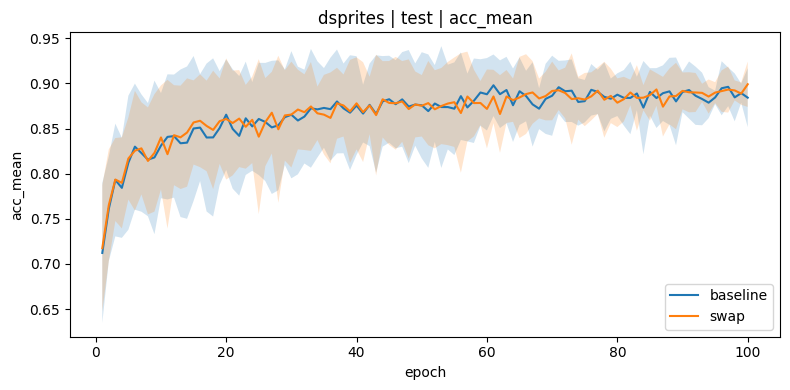

Plot dataset=mpi3d metric=acc_mean


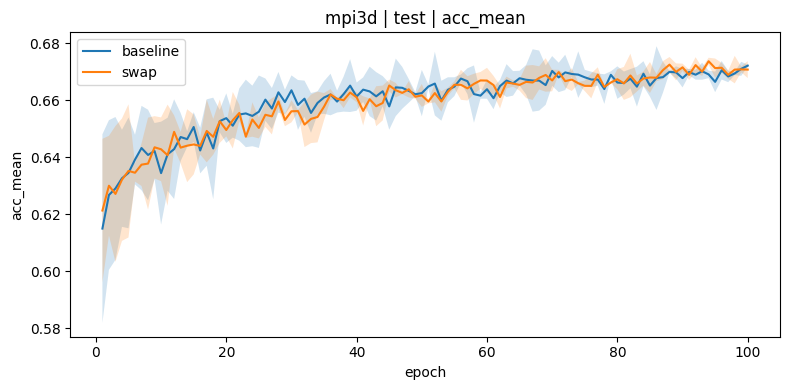

In [14]:
def plot_curves_by_dataset(df_metrics: pd.DataFrame, dataset: str, metric: str, split: str = "test"):
    d = df_metrics[df_metrics["dataset"] == dataset].copy()
    if len(d) == 0:
        print(f"No hay datos para dataset={dataset}")
        return
    if metric not in d.columns:
        print(f"Métrica '{metric}' no existe para dataset={dataset}.")
        return

    d = d[d["split"] == split].dropna(subset=["epoch", metric])
    if len(d) == 0:
        print(f"No hay filas para split={split} con métrica={metric}.")
        return

    grp = d.groupby(["train_mode","epoch"])[metric].agg(["mean","std"]).reset_index()

    plt.figure(figsize=(8,4))
    for mode, g in grp.groupby("train_mode"):
        plt.plot(g["epoch"], g["mean"], label=str(mode))
        if g["std"].notna().any():
            lo = (g["mean"] - g["std"]).to_numpy()
            hi = (g["mean"] + g["std"]).to_numpy()
            plt.fill_between(g["epoch"], lo, hi, alpha=0.2)

    plt.xlabel("epoch")
    plt.ylabel(metric)
    plt.title(f"{dataset} | {split} | {metric}")
    plt.legend()
    plt.tight_layout()
    plt.show()

def auto_metric_for_dataset(df_best: pd.DataFrame, dataset: str) -> str:
    d = df_best[df_best["dataset"] == dataset]
    if len(d) == 0:
        return "loss"
    return d["select_metric"].value_counts().index[0]

for dataset in sorted(df_metrics["dataset"].dropna().unique()):
    m = auto_metric_for_dataset(df_best, dataset)
    print(f"Plot dataset={dataset} metric={m}")
    plot_curves_by_dataset(df_metrics, dataset, metric=m, split="test")


## 6) Barras en TEST por dataset

Métrica primaria:
- `acc_mean` si existe, si no `acc_num`, si no alguna `acc_*`, si no `loss`.


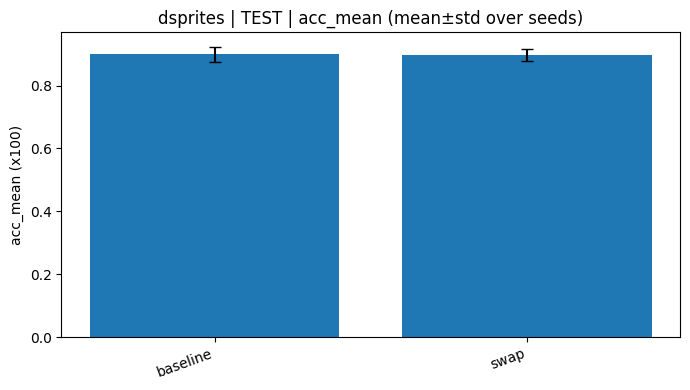

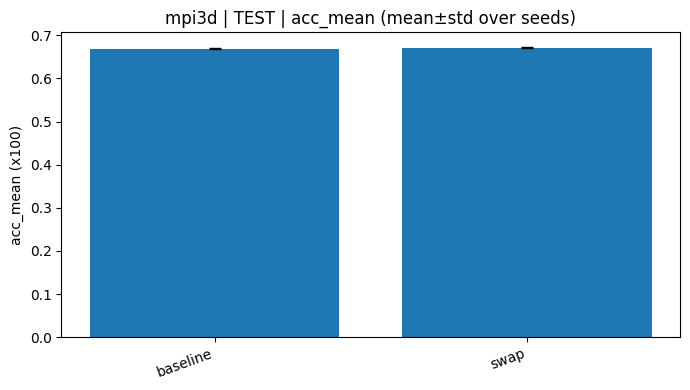

In [12]:
def pick_primary_test_metric(d: pd.DataFrame) -> Optional[str]:
    for m in ["acc_mean","acc_num","acc_scale","acc_rot","acc_font","acc_color"]:
        if m in d.columns and d[m].notna().any():
            return m
    accs = [c for c in d.columns if c.startswith("acc_") and d[c].notna().any()]
    if accs:
        return accs[0]
    if "loss" in d.columns and d["loss"].notna().any():
        return "loss"
    return None

def barplot_test_metric_by_method(df_test_best: pd.DataFrame, dataset: str):
    d = df_test_best[df_test_best["dataset"] == dataset].copy()
    if len(d) == 0:
        return
    metric = pick_primary_test_metric(d)
    if metric is None:
        print(f"[WARN] No hay métrica primaria para {dataset}")
        return

    grp = d.groupby("train_mode")[metric].agg(["mean","std"]).sort_index()
    x = np.arange(len(grp.index))

    plt.figure(figsize=(7,4))
    plt.bar(x, grp["mean"].to_numpy(), yerr=grp["std"].to_numpy(), capsize=4)
    plt.xticks(x, [str(i) for i in grp.index], rotation=20, ha="right")
    plt.ylabel(metric + (" (x100)" if metric.startswith("acc") else ""))
    plt.title(f"{dataset} | TEST | {metric} (mean±std over seeds)")
    plt.tight_layout()
    plt.show()

for dataset in sorted(df_test_best["dataset"].dropna().unique()):
    barplot_test_metric_by_method(df_test_best, dataset)


## 7) Exportar resultados

Se exportan 3 CSV en `EXPORT_DIR`:
- `best_epoch_per_runseed.csv`
- `val_at_best_epoch.csv`
- `test_at_best_epoch.csv`


In [ ]:
df_best.to_csv(EXPORT_DIR / "best_epoch_per_runseed.csv", index=False)
df_val_best.to_csv(EXPORT_DIR / "val_at_best_epoch.csv", index=False)
df_test_best.to_csv(EXPORT_DIR / "test_at_best_epoch.csv", index=False)

print("Exportado en:", EXPORT_DIR.resolve())


## 8) Sanity checks

Si ves 100% en todo (p.ej. Shapes3D):
- Verifica que realmente estás mirando filas con `split == "test"` (y no `train`).
- Confirma que tu `train.py` evalúa val/test **sin aplicar swap/manip** (swap/manip solo para entrenar).


In [ ]:
if len(df_metrics) > 0:
    display(df_metrics.pivot_table(index=["dataset","split"], values="epoch", aggfunc="count").rename(columns={"epoch":"rows"}))
